In [1]:
import os  # this enables XLA optimized computations
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
import tensorflow as tf
from tensorflow import keras

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from data.pre_processing import DataPreparer
from data.train_test_manager import DataManager
from experiment_executor.pcdnn_v2_experiment_executor import PCDNNV2ExperimentExecutor
from models.pcdnnv2_model_factory import PCDNNV2ModelFactory

2022-11-02 20:18:53.982727: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
exprExec = PCDNNV2ExperimentExecutor()
exprExec.use_dynamic_pred = True
exprExec.use_dependants = True

print(dir(exprExec))

exprExec.setModelFactory(PCDNNV2ModelFactory())
bestModel, experimentSettings = exprExec.modelFactory.openBestModel()
assert experimentSettings['ipscaler']==None # we cannot center data, as it makes transform non-linear
bestModel = exprExec.modelFactory.getEmbRegressor() # shed container model
dm = experimentSettings['data_manager']

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_modelFactory', 'batch_size', 'best_model_path', 'best_model_score', 'compute_model_score', 'df_err', 'df_experimentTracker', 'dm', 'err', 'errManager', 'executeExperiments', 'executeSingleExperiment', 'fitModelAndCalcErr', 'fit_time', 'getPredictons', 'model', 'modelFactory', 'modelType', 'n_epochs_override', 'n_models_override', 'plot_loss_physics_and_regression', 'pred_time', 'predictions', 'prepare_model_data_dicts', 'setModel', 'setModelFactory', 'use_dependants', 'use_dynamic_pred']
Parent DNNModelFactory Instantiated
Parent DNNModelFactory Instantiated


2022-11-02 20:18:55.789183: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 20:18:55.798154: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x55dc29d31b00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-11-02 20:18:55.798172: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): Host, Default Version
2022-11-02 20:18:55.887029: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x55dc29e40700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-02 20:18:55.887061: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): Quadro RTX 5000,

In [3]:
dm.constants.createPCAs()
df = dm.constants.getDataframe()
pure_pca_cols = [col for col in df.columns if 'PURE' in col]

pure_pca_data = df[pure_pca_cols]

In [24]:
import pandas as pd
from tensorflow.keras import layers as L
import tensorflow_addons as tfa

def R2(yt,yp): return tf.reduce_mean(1-tf.reduce_mean((yp-yt)**2, axis=0)/(tf.math.reduce_std(yt,axis=0)**2))

# Standard Scaler is super important for getting well behaved loss & error metrics!!
# (I'm not sure why could be because )
from sklearn.preprocessing import *

def build_mass_fraction_model(n_species=53):
    mass_fraction_pred = keras.models.Sequential()
    #layer_sizes = [32,64,128,256,512,256,128,64,32]
    layer_sizes = [64, 64, 64, 64] # TODO: use less layers
    for size in layer_sizes:
        mass_fraction_pred.add(L.Dense(size, activation='selu'))
        mass_fraction_pred.add(L.BatchNormalization())
        mass_fraction_pred.add(L.Dropout(0.1))
    mass_fraction_pred.add(L.Dense(n_species))
    mass_fraction_pred.compile(optimizer='adam',loss='mse', metrics=['mape', R2, tfa.metrics.RSquare()])
    return mass_fraction_pred

data = pd.read_csv('models/best_models/PCDNNV2Model/PCA_data.csv')#dm.df
noOfNeurons = len(experimentSettings['input_data_cols'])
#input_data = data[[f'PCDNNV2_PCA_{i+1}' for i in range(experimentSettings['noOfCpv'])]]
input_data = pure_pca_data #data[[f'Pure_PCA_{i+1}' for i in range(experimentSettings['noOfCpv'])]]
#input_data = data[[f'PCDNNV2_PCA_source_{i+1}' for i in range(experimentSettings['noOfCpv'])]]
output_data = data[[c for c in data.columns if c.startswith('Yi')]]
mass_scaler = StandardScaler()
output_data = mass_scaler.fit_transform(output_data)

mass_fraction_pred = build_mass_fraction_model(noOfNeurons)

In [25]:
mass_fraction_pred.fit(input_data, output_data, epochs=1000, shuffle=True, validation_split=0.2, batch_size=256)
mass_fraction_pred.save('mass_fraction_pred_model.h5')

Epoch 1/1000
59/59 [==============================] - 2s 13ms/step - loss: 0.9356 - mape: 905.1959 - R2: -5.0799 - r_square: 0.1798 - val_loss: 0.1722 - val_mape: 180.4070 - val_R2: -inf - val_r_square: 4518506.5000
Epoch 2/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.4923 - mape: 1357.0653 - R2: -1.2485 - r_square: 0.5729 - val_loss: 0.1306 - val_mape: 153.0221 - val_R2: -inf - val_r_square: 1607280.0000
Epoch 3/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.4085 - mape: 1206.0652 - R2: -1.0859 - r_square: 0.6465 - val_loss: 0.0946 - val_mape: 125.0819 - val_R2: -inf - val_r_square: -684486.9375
Epoch 4/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.3562 - mape: 723.2414 - R2: -0.9425 - r_square: 0.6928 - val_loss: 0.0698 - val_mape: 108.0596 - val_R2: -inf - val_r_square: -1411222.6250
Epoch 5/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.3183 - mape: 759.7768 - R2: -0.3108 - r_square: 0.7261 -

59/59 [==============================] - 1s 11ms/step - loss: 0.1493 - mape: 515.4714 - R2: 0.3061 - r_square: 0.8733 - val_loss: 0.0169 - val_mape: 46.5851 - val_R2: -inf - val_r_square: -616900.3750
Epoch 40/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1501 - mape: 242.4437 - R2: 0.5874 - r_square: 0.8725 - val_loss: 0.0155 - val_mape: 44.3187 - val_R2: -inf - val_r_square: -426772.5000
Epoch 41/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.1466 - mape: 881.8817 - R2: 0.6298 - r_square: 0.8754 - val_loss: 0.0152 - val_mape: 47.0169 - val_R2: -inf - val_r_square: -775094.1250
Epoch 42/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.1473 - mape: 454.5518 - R2: 0.4971 - r_square: 0.8750 - val_loss: 0.0154 - val_mape: 42.7713 - val_R2: -inf - val_r_square: -625452.0000
Epoch 43/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1443 - mape: 827.9811 - R2: 0.6345 - r_square: 0.8775 - val_loss: 0.0156 - v

59/59 [==============================] - 1s 10ms/step - loss: 0.1235 - mape: 269.8513 - R2: -0.0664 - r_square: 0.8950 - val_loss: 0.0127 - val_mape: 37.0461 - val_R2: -inf - val_r_square: -447396.1562
Epoch 78/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.1277 - mape: 416.8092 - R2: -0.6584 - r_square: 0.8915 - val_loss: 0.0123 - val_mape: 38.3664 - val_R2: -inf - val_r_square: -772231.3125
Epoch 79/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.1217 - mape: 768.7722 - R2: -0.2546 - r_square: 0.8963 - val_loss: 0.0139 - val_mape: 38.1507 - val_R2: -inf - val_r_square: -823890.0625
Epoch 80/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1225 - mape: 396.2520 - R2: -0.1545 - r_square: 0.8958 - val_loss: 0.0128 - val_mape: 39.6161 - val_R2: -inf - val_r_square: -529939.8750
Epoch 81/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1217 - mape: 617.6613 - R2: -0.6799 - r_square: 0.8963 - val_loss: 0.012

Epoch 115/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1147 - mape: 399.0234 - R2: -1.7749 - r_square: 0.9025 - val_loss: 0.0112 - val_mape: 34.9188 - val_R2: -inf - val_r_square: -188213.4375
Epoch 116/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.1165 - mape: 324.0958 - R2: -1.8803 - r_square: 0.9009 - val_loss: 0.0108 - val_mape: 35.3789 - val_R2: -inf - val_r_square: -266322.7812
Epoch 117/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1126 - mape: 225.9224 - R2: -1.3685 - r_square: 0.9040 - val_loss: 0.0101 - val_mape: 35.7781 - val_R2: -inf - val_r_square: -154035.7500
Epoch 118/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1135 - mape: 462.0143 - R2: -0.8298 - r_square: 0.9035 - val_loss: 0.0112 - val_mape: 34.7264 - val_R2: -inf - val_r_square: -144011.6250
Epoch 119/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.1130 - mape: 409.7128 - R2: -0.2384 - r_square: 0.903

Epoch 153/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.1105 - mape: 252.7985 - R2: -1.9917 - r_square: 0.9060 - val_loss: 0.0098 - val_mape: 36.0376 - val_R2: -inf - val_r_square: -193815.4531
Epoch 154/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1111 - mape: 266.9421 - R2: -0.0189 - r_square: 0.9054 - val_loss: 0.0093 - val_mape: 35.1413 - val_R2: -inf - val_r_square: -209206.0000
Epoch 155/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1086 - mape: 142.7645 - R2: -1.7433 - r_square: 0.9075 - val_loss: 0.0100 - val_mape: 33.5947 - val_R2: -inf - val_r_square: -124344.2422
Epoch 156/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1107 - mape: 473.5520 - R2: -0.4140 - r_square: 0.9056 - val_loss: 0.0093 - val_mape: 35.2632 - val_R2: -inf - val_r_square: -113438.6328
Epoch 157/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1106 - mape: 521.7075 - R2: -0.1816 - r_square: 0.905

Epoch 191/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1081 - mape: 219.0598 - R2: -0.6461 - r_square: 0.9081 - val_loss: 0.0096 - val_mape: 36.0771 - val_R2: -inf - val_r_square: 27784.0918
Epoch 192/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1096 - mape: 454.6357 - R2: -0.4321 - r_square: 0.9068 - val_loss: 0.0088 - val_mape: 34.5897 - val_R2: -inf - val_r_square: -198136.7188
Epoch 193/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1061 - mape: 292.5417 - R2: -1.6316 - r_square: 0.9097 - val_loss: 0.0087 - val_mape: 36.1885 - val_R2: -inf - val_r_square: -155544.5156
Epoch 194/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1046 - mape: 332.7577 - R2: -1.8497 - r_square: 0.9109 - val_loss: 0.0081 - val_mape: 34.8678 - val_R2: -inf - val_r_square: -236103.8438
Epoch 195/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.1077 - mape: 162.3077 - R2: -0.3021 - r_square: 0.9082 

Epoch 229/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1045 - mape: 449.6225 - R2: -0.7889 - r_square: 0.9110 - val_loss: 0.0093 - val_mape: 33.2559 - val_R2: -inf - val_r_square: -150669.1562
Epoch 230/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1046 - mape: 444.4872 - R2: -0.9770 - r_square: 0.9110 - val_loss: 0.0088 - val_mape: 33.2634 - val_R2: -inf - val_r_square: -247996.9219
Epoch 231/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1047 - mape: 703.4689 - R2: -0.9197 - r_square: 0.9107 - val_loss: 0.0087 - val_mape: 35.0220 - val_R2: -inf - val_r_square: -140049.7344
Epoch 232/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1066 - mape: 629.8998 - R2: -2.6528 - r_square: 0.9092 - val_loss: 0.0100 - val_mape: 34.2910 - val_R2: -inf - val_r_square: -130467.3672
Epoch 233/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.1059 - mape: 452.7408 - R2: -0.6665 - r_square: 0.909

Epoch 267/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1052 - mape: 300.3824 - R2: -3.3694 - r_square: 0.9104 - val_loss: 0.0085 - val_mape: 33.4793 - val_R2: -inf - val_r_square: -112517.7109
Epoch 268/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.1031 - mape: 636.1385 - R2: -0.3546 - r_square: 0.9122 - val_loss: 0.0094 - val_mape: 35.0907 - val_R2: -inf - val_r_square: -91242.1797
Epoch 269/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1044 - mape: 535.7118 - R2: -0.2696 - r_square: 0.9111 - val_loss: 0.0093 - val_mape: 33.8452 - val_R2: -inf - val_r_square: -207214.9219
Epoch 270/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1025 - mape: 443.6768 - R2: -0.5155 - r_square: 0.9127 - val_loss: 0.0093 - val_mape: 34.9527 - val_R2: -inf - val_r_square: -55697.8477
Epoch 271/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0998 - mape: 220.3593 - R2: 0.0143 - r_square: 0.9150 -

Epoch 305/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0982 - mape: 380.0039 - R2: -0.4109 - r_square: 0.9162 - val_loss: 0.0095 - val_mape: 34.7969 - val_R2: -inf - val_r_square: -215349.6094
Epoch 306/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.1040 - mape: 303.3272 - R2: -0.6455 - r_square: 0.9114 - val_loss: 0.0097 - val_mape: 36.9890 - val_R2: -inf - val_r_square: -229996.0625
Epoch 307/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1020 - mape: 474.8687 - R2: -0.0082 - r_square: 0.9131 - val_loss: 0.0091 - val_mape: 33.8861 - val_R2: -inf - val_r_square: 44739.1641
Epoch 308/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0979 - mape: 575.3831 - R2: -0.4953 - r_square: 0.9164 - val_loss: 0.0085 - val_mape: 33.4971 - val_R2: -inf - val_r_square: -96996.3984
Epoch 309/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1004 - mape: 368.4553 - R2: -1.1912 - r_square: 0.9143 -

Epoch 343/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0980 - mape: 1024.0981 - R2: -0.7746 - r_square: 0.9164 - val_loss: 0.0087 - val_mape: 33.3244 - val_R2: -inf - val_r_square: -23025.1602
Epoch 344/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0988 - mape: 440.9529 - R2: -0.7594 - r_square: 0.9158 - val_loss: 0.0091 - val_mape: 35.0430 - val_R2: -inf - val_r_square: 136710.6250
Epoch 345/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.1019 - mape: 368.8537 - R2: -0.8469 - r_square: 0.9131 - val_loss: 0.0099 - val_mape: 35.4911 - val_R2: -inf - val_r_square: 166271.3906
Epoch 346/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.1005 - mape: 456.4744 - R2: -1.3269 - r_square: 0.9141 - val_loss: 0.0089 - val_mape: 34.6767 - val_R2: -inf - val_r_square: 76030.4375
Epoch 347/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1003 - mape: 483.3369 - R2: -0.0804 - r_square: 0.9145 - 

Epoch 381/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0972 - mape: 365.0817 - R2: -0.7434 - r_square: 0.9171 - val_loss: 0.0096 - val_mape: 34.5392 - val_R2: -inf - val_r_square: 226587.3906
Epoch 382/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.1004 - mape: 536.0825 - R2: -1.3811 - r_square: 0.9144 - val_loss: 0.0083 - val_mape: 36.8041 - val_R2: -inf - val_r_square: 404262.5938
Epoch 383/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.1001 - mape: 328.8640 - R2: -0.6207 - r_square: 0.9146 - val_loss: 0.0094 - val_mape: 38.2522 - val_R2: -inf - val_r_square: -96380.8359
Epoch 384/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.1007 - mape: 271.7853 - R2: -0.7430 - r_square: 0.9141 - val_loss: 0.0084 - val_mape: 34.6382 - val_R2: -inf - val_r_square: 205507.4219
Epoch 385/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0977 - mape: 663.0022 - R2: -1.2337 - r_square: 0.9167 - 

Epoch 419/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0967 - mape: 654.1215 - R2: -0.9705 - r_square: 0.9174 - val_loss: 0.0094 - val_mape: 35.6484 - val_R2: -inf - val_r_square: 252528.4375
Epoch 420/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0983 - mape: 381.2869 - R2: -1.2663 - r_square: 0.9160 - val_loss: 0.0132 - val_mape: 41.5214 - val_R2: -inf - val_r_square: 210445.4688
Epoch 421/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0958 - mape: 267.6296 - R2: -2.2979 - r_square: 0.9183 - val_loss: 0.0088 - val_mape: 36.8057 - val_R2: -inf - val_r_square: 43046.2266
Epoch 422/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0962 - mape: 783.1202 - R2: -0.7722 - r_square: 0.9178 - val_loss: 0.0105 - val_mape: 38.8670 - val_R2: -inf - val_r_square: -1130505.2500
Epoch 423/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0968 - mape: 485.8312 - R2: -0.4855 - r_square: 0.9174 -

Epoch 457/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0936 - mape: 324.5399 - R2: -0.6882 - r_square: 0.9198 - val_loss: 0.0093 - val_mape: 37.2889 - val_R2: -inf - val_r_square: 470468.2500
Epoch 458/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0931 - mape: 621.5209 - R2: -1.2679 - r_square: 0.9203 - val_loss: 0.0100 - val_mape: 40.5399 - val_R2: -inf - val_r_square: -427140.3438
Epoch 459/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0963 - mape: 423.9855 - R2: -1.9864 - r_square: 0.9177 - val_loss: 0.0112 - val_mape: 40.3907 - val_R2: -inf - val_r_square: 635585.9375
Epoch 460/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0956 - mape: 499.8826 - R2: -0.8455 - r_square: 0.9183 - val_loss: 0.0094 - val_mape: 35.1048 - val_R2: -inf - val_r_square: -201787.9375
Epoch 461/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0932 - mape: 687.0808 - R2: -0.8158 - r_square: 0.9202 

Epoch 495/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0920 - mape: 478.1111 - R2: -1.2051 - r_square: 0.9210 - val_loss: 0.0094 - val_mape: 42.1311 - val_R2: -inf - val_r_square: 224003.0156
Epoch 496/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1019 - mape: 311.3989 - R2: -2.5765 - r_square: 0.9133 - val_loss: 0.0116 - val_mape: 39.4730 - val_R2: -inf - val_r_square: -960211.0000
Epoch 497/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.1003 - mape: 292.3190 - R2: -1.6446 - r_square: 0.9144 - val_loss: 0.0101 - val_mape: 38.3521 - val_R2: -inf - val_r_square: -178981.0938
Epoch 498/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.1003 - mape: 264.1598 - R2: -1.5786 - r_square: 0.9144 - val_loss: 0.0097 - val_mape: 40.1940 - val_R2: -inf - val_r_square: -158632.5469
Epoch 499/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0927 - mape: 481.2745 - R2: -1.6520 - r_square: 0.9205

Epoch 533/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0927 - mape: 360.5921 - R2: -1.9927 - r_square: 0.9206 - val_loss: 0.0099 - val_mape: 40.6031 - val_R2: -inf - val_r_square: 147909.2344
Epoch 534/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0917 - mape: 628.3624 - R2: -1.6207 - r_square: 0.9214 - val_loss: 0.0094 - val_mape: 36.5434 - val_R2: -inf - val_r_square: 665546.4375
Epoch 535/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0919 - mape: 527.5320 - R2: -2.1207 - r_square: 0.9212 - val_loss: 0.0100 - val_mape: 42.5616 - val_R2: -inf - val_r_square: 1599860.6250
Epoch 536/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0886 - mape: 1147.4938 - R2: -1.4684 - r_square: 0.9240 - val_loss: 0.0101 - val_mape: 39.8147 - val_R2: -inf - val_r_square: 1190515.8750
Epoch 537/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0912 - mape: 1198.7767 - R2: -1.4616 - r_square: 0.921

Epoch 571/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0956 - mape: 584.0565 - R2: -6.2984 - r_square: 0.9183 - val_loss: 0.0094 - val_mape: 40.0208 - val_R2: -inf - val_r_square: 552993.6250
Epoch 572/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0911 - mape: 319.9152 - R2: -4.7366 - r_square: 0.9221 - val_loss: 0.0100 - val_mape: 40.7014 - val_R2: -inf - val_r_square: 1345800.0000
Epoch 573/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0911 - mape: 336.5512 - R2: -1.8274 - r_square: 0.9220 - val_loss: 0.0109 - val_mape: 37.7272 - val_R2: -inf - val_r_square: 629506.1250
Epoch 574/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0938 - mape: 919.5424 - R2: -2.9319 - r_square: 0.9196 - val_loss: 0.0100 - val_mape: 38.4308 - val_R2: -inf - val_r_square: 1069747.8750
Epoch 575/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0867 - mape: 308.9659 - R2: -1.8170 - r_square: 0.9255 

Epoch 609/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0870 - mape: 300.4360 - R2: -1.6659 - r_square: 0.9252 - val_loss: 0.0098 - val_mape: 35.8401 - val_R2: -inf - val_r_square: -420656.0312
Epoch 610/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0870 - mape: 800.4744 - R2: -1.7262 - r_square: 0.9253 - val_loss: 0.0092 - val_mape: 37.8665 - val_R2: -inf - val_r_square: 599522.4375
Epoch 611/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1041 - mape: 264.2134 - R2: -2.8604 - r_square: 0.9113 - val_loss: 0.0113 - val_mape: 49.1653 - val_R2: -inf - val_r_square: 2296639.0000
Epoch 612/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0946 - mape: 223.9164 - R2: -2.9564 - r_square: 0.9190 - val_loss: 0.0092 - val_mape: 39.4384 - val_R2: -inf - val_r_square: 753630.8750
Epoch 613/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0880 - mape: 461.5896 - R2: -6.1510 - r_square: 0.9244 

Epoch 647/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0853 - mape: 621.3682 - R2: -1.4876 - r_square: 0.9266 - val_loss: 0.0090 - val_mape: 40.3177 - val_R2: -inf - val_r_square: 27014.5527
Epoch 648/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0877 - mape: 241.5588 - R2: -1.9353 - r_square: 0.9246 - val_loss: 0.0090 - val_mape: 39.0600 - val_R2: -inf - val_r_square: 194621.6250
Epoch 649/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0867 - mape: 225.0534 - R2: -1.6590 - r_square: 0.9255 - val_loss: 0.0096 - val_mape: 39.8008 - val_R2: -inf - val_r_square: 1408863.5000
Epoch 650/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0914 - mape: 330.6653 - R2: -2.4590 - r_square: 0.9216 - val_loss: 0.0106 - val_mape: 39.4845 - val_R2: -inf - val_r_square: 74854.7109
Epoch 651/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1029 - mape: 360.8667 - R2: -2.8670 - r_square: 0.9122 - v

Epoch 685/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0893 - mape: 453.3214 - R2: -1.6525 - r_square: 0.9235 - val_loss: 0.0099 - val_mape: 38.4137 - val_R2: -inf - val_r_square: 1338505.2500
Epoch 686/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0888 - mape: 506.0901 - R2: -2.9944 - r_square: 0.9236 - val_loss: 0.0089 - val_mape: 40.1268 - val_R2: -inf - val_r_square: 1484982.2500
Epoch 687/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0901 - mape: 896.8596 - R2: -2.1470 - r_square: 0.9227 - val_loss: 0.0091 - val_mape: 38.4199 - val_R2: -inf - val_r_square: 1284192.0000
Epoch 688/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0839 - mape: 595.3221 - R2: -1.4920 - r_square: 0.9277 - val_loss: 0.0093 - val_mape: 34.6536 - val_R2: -inf - val_r_square: 481911.7812
Epoch 689/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0844 - mape: 525.6552 - R2: -1.9323 - r_square: 0.9274

Epoch 723/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0844 - mape: 408.5683 - R2: -3.7703 - r_square: 0.9274 - val_loss: 0.0085 - val_mape: 44.4621 - val_R2: -inf - val_r_square: 3404112.2500
Epoch 724/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0870 - mape: 752.0210 - R2: -1.6791 - r_square: 0.9252 - val_loss: 0.0102 - val_mape: 38.7073 - val_R2: -inf - val_r_square: 575279.1250
Epoch 725/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0884 - mape: 423.8273 - R2: -2.1940 - r_square: 0.9239 - val_loss: 0.0104 - val_mape: 36.7023 - val_R2: -inf - val_r_square: 477329.5938
Epoch 726/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0919 - mape: 193.6616 - R2: -2.1502 - r_square: 0.9212 - val_loss: 0.0109 - val_mape: 45.4201 - val_R2: -inf - val_r_square: 3031999.5000
Epoch 727/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0918 - mape: 767.5274 - R2: -2.5787 - r_square: 0.9213 

Epoch 761/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0859 - mape: 465.8971 - R2: -2.9618 - r_square: 0.9261 - val_loss: 0.0099 - val_mape: 35.5613 - val_R2: -inf - val_r_square: 370763.6875
Epoch 762/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0865 - mape: 410.7788 - R2: -1.5237 - r_square: 0.9257 - val_loss: 0.0088 - val_mape: 35.8984 - val_R2: -inf - val_r_square: 593597.0000
Epoch 763/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0827 - mape: 809.5041 - R2: -3.1955 - r_square: 0.9288 - val_loss: 0.0085 - val_mape: 36.8450 - val_R2: -inf - val_r_square: 982293.3750
Epoch 764/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0865 - mape: 629.2074 - R2: -1.3885 - r_square: 0.9258 - val_loss: 0.0085 - val_mape: 36.6677 - val_R2: -inf - val_r_square: 1074612.6250
Epoch 765/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0879 - mape: 348.9606 - R2: -2.0612 - r_square: 0.9244 -

Epoch 799/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0858 - mape: 510.6327 - R2: -1.9384 - r_square: 0.9261 - val_loss: 0.0087 - val_mape: 39.6269 - val_R2: -inf - val_r_square: 1950527.8750
Epoch 800/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0816 - mape: 696.5760 - R2: -1.8028 - r_square: 0.9295 - val_loss: 0.0085 - val_mape: 34.7393 - val_R2: -inf - val_r_square: 767134.5000
Epoch 801/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0851 - mape: 849.0807 - R2: -1.5381 - r_square: 0.9269 - val_loss: 0.0089 - val_mape: 33.8377 - val_R2: -inf - val_r_square: 532057.0625
Epoch 802/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.1095 - mape: 357.5850 - R2: -2.0590 - r_square: 0.9072 - val_loss: 0.0138 - val_mape: 52.9418 - val_R2: -inf - val_r_square: 6581801.0000
Epoch 803/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0921 - mape: 225.4490 - R2: -2.6168 - r_square: 0.9211 

Epoch 837/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0825 - mape: 524.7067 - R2: -1.6622 - r_square: 0.9288 - val_loss: 0.0082 - val_mape: 36.9617 - val_R2: -inf - val_r_square: 1119809.8750
Epoch 838/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0824 - mape: 488.2635 - R2: -2.1667 - r_square: 0.9288 - val_loss: 0.0095 - val_mape: 36.0483 - val_R2: -inf - val_r_square: 987125.3750
Epoch 839/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0859 - mape: 680.4648 - R2: -2.7244 - r_square: 0.9259 - val_loss: 0.0105 - val_mape: 44.2433 - val_R2: -inf - val_r_square: 4785768.5000
Epoch 840/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0816 - mape: 1014.3414 - R2: -1.7093 - r_square: 0.9296 - val_loss: 0.0095 - val_mape: 38.1141 - val_R2: -inf - val_r_square: 1797742.6250
Epoch 841/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0814 - mape: 740.3163 - R2: -2.3396 - r_square: 0.929

Epoch 875/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0840 - mape: 318.1692 - R2: -3.2020 - r_square: 0.9276 - val_loss: 0.0119 - val_mape: 48.9285 - val_R2: -inf - val_r_square: 3123129.0000
Epoch 876/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.1066 - mape: 519.6447 - R2: -2.5637 - r_square: 0.9094 - val_loss: 0.0102 - val_mape: 39.0550 - val_R2: -inf - val_r_square: 2040662.5000
Epoch 877/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0909 - mape: 809.6297 - R2: -1.6052 - r_square: 0.9222 - val_loss: 0.0096 - val_mape: 38.1459 - val_R2: -inf - val_r_square: 1594721.5000
Epoch 878/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0827 - mape: 840.7622 - R2: -2.1604 - r_square: 0.9286 - val_loss: 0.0097 - val_mape: 33.4850 - val_R2: -inf - val_r_square: 660334.6875
Epoch 879/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0879 - mape: 772.9166 - R2: -3.0681 - r_square: 0.9246

Epoch 913/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0819 - mape: 449.7772 - R2: -2.3693 - r_square: 0.9293 - val_loss: 0.0100 - val_mape: 38.1156 - val_R2: -inf - val_r_square: 1450933.1250
Epoch 914/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0823 - mape: 513.0886 - R2: -2.7242 - r_square: 0.9290 - val_loss: 0.0090 - val_mape: 37.4875 - val_R2: -inf - val_r_square: 1392021.3750
Epoch 915/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0813 - mape: 376.3976 - R2: -2.3482 - r_square: 0.9299 - val_loss: 0.0091 - val_mape: 40.9427 - val_R2: -inf - val_r_square: 2807464.7500
Epoch 916/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0840 - mape: 394.9106 - R2: -2.2279 - r_square: 0.9275 - val_loss: 0.0088 - val_mape: 41.3714 - val_R2: -inf - val_r_square: 3228788.5000
Epoch 917/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0824 - mape: 539.4421 - R2: -1.7709 - r_square: 0.928

Epoch 951/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0854 - mape: 675.4651 - R2: -2.1624 - r_square: 0.9264 - val_loss: 0.0110 - val_mape: 45.8312 - val_R2: -inf - val_r_square: 5235892.5000
Epoch 952/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0848 - mape: 279.5473 - R2: -1.8432 - r_square: 0.9269 - val_loss: 0.0096 - val_mape: 43.7817 - val_R2: -inf - val_r_square: 3414135.0000
Epoch 953/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0833 - mape: 230.7264 - R2: -1.8550 - r_square: 0.9283 - val_loss: 0.0091 - val_mape: 45.2436 - val_R2: -inf - val_r_square: 4166198.7500
Epoch 954/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0817 - mape: 274.6221 - R2: -2.1248 - r_square: 0.9296 - val_loss: 0.0111 - val_mape: 45.5188 - val_R2: -inf - val_r_square: 4629293.0000
Epoch 955/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0795 - mape: 218.2931 - R2: -1.5585 - r_square: 0.931

Epoch 989/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0818 - mape: 400.6443 - R2: -1.6873 - r_square: 0.9294 - val_loss: 0.0100 - val_mape: 40.0022 - val_R2: -inf - val_r_square: 2758524.7500
Epoch 990/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0795 - mape: 268.9522 - R2: -3.0888 - r_square: 0.9314 - val_loss: 0.0094 - val_mape: 41.7099 - val_R2: -inf - val_r_square: 3805586.5000
Epoch 991/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0805 - mape: 976.0125 - R2: -4.1007 - r_square: 0.9306 - val_loss: 0.0090 - val_mape: 43.8553 - val_R2: -inf - val_r_square: 3744634.7500
Epoch 992/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0826 - mape: 539.6180 - R2: -1.9421 - r_square: 0.9287 - val_loss: 0.0101 - val_mape: 43.9326 - val_R2: -inf - val_r_square: 4313502.5000
Epoch 993/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0822 - mape: 465.1614 - R2: -1.6205 - r_square: 0.929

In [43]:
import numpy as np
linear_embedder = bestModel.get_layer('linear_embedding')
CPVs = linear_embedder.predict(output_data)
assert np.allclose(input_data, CPVs) # verified that PCDNNV2 CPV data is correct! 

In [28]:
mass_fraction_pred.evaluate(input_data, output_data, batch_size=100000)

1/1 [==============================] - 0s 26ms/step - loss: 103132.8203 - mape: 103132.8203 - r_square: -7489711030445015040.0000


[103132.8203125, 103132.8203125, -7.489711030445015e+18]

Text(0.5, 1.0, 'Final R^2 of best model')

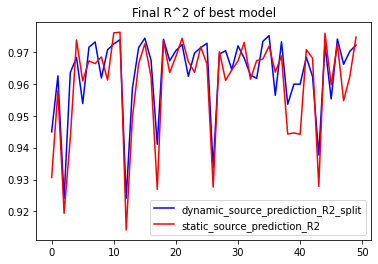

In [23]:
import matplotlib.pyplot as plt

plt.plot(experimentSettings['history']['val_dynamic_source_prediction_R2_split'][-50:], color='blue')
plt.plot(experimentSettings['history']['val_static_source_prediction_R2'][-50:], color='red')
plt.legend(['dynamic_source_prediction_R2_split', 'static_source_prediction_R2'])
plt.title('Final R^2 of best model')

In [ ]:
!pip install tensorflow-addons

In [ ]:
import tensorflow_addons as tfa

In [32]:
exprExec.compute_model_score(experimentSettings['history'], beta=0.7)

0.9706506389689524

In [24]:
print(experimentSettings['history']['val_dynamic_source_prediction_R2_split'][-1])
print(experimentSettings['history']['val_static_source_prediction_R2'][-1])

0.9721474051475525
0.9746561050415039


In [22]:
dm.input_data_cols

['YiCH4',
 'YiH',
 'YiO',
 'YiO2',
 'YiOH',
 'YiH2O',
 'YiHO2',
 'YiH2O2',
 'YiC',
 'YiCH',
 'YiCH2',
 'YiCH2(S)',
 'YiCH3',
 'YiH2',
 'YiCO',
 'YiCO2',
 'YiHCO',
 'YiCH2O',
 'YiCH2OH',
 'YiCH3O',
 'YiCH3OH',
 'YiC2H',
 'YiC2H2',
 'YiC2H3',
 'YiC2H4',
 'YiC2H5',
 'YiC2H6',
 'YiHCCO',
 'YiCH2CO',
 'YiHCCOH',
 'YiN',
 'YiNH',
 'YiNH2',
 'YiNH3',
 'YiNNH',
 'YiNO',
 'YiNO2',
 'YiN2O',
 'YiHNO',
 'YiCN',
 'YiHCN',
 'YiH2CN',
 'YiHCNN',
 'YiHCNO',
 'YiHOCN',
 'YiHNCO',
 'YiNCO',
 'YiC3H7',
 'YiC3H8',
 'YiCH2CHO',
 'YiCH3CHO',
 'YiN2',
 'YiAR']

In [23]:
int('blah')

ValueError: invalid literal for int() with base 10: 'blah'